19:00:09 - cmdstanpy - INFO - Chain [1] start processing
19:00:11 - cmdstanpy - INFO - Chain [1] done processing
19:00:12 - cmdstanpy - INFO - Chain [1] start processing
19:00:20 - cmdstanpy - INFO - Chain [1] done processing
19:00:21 - cmdstanpy - INFO - Chain [1] start processing
19:00:32 - cmdstanpy - INFO - Chain [1] done processing
19:00:32 - cmdstanpy - INFO - Chain [1] start processing
19:00:34 - cmdstanpy - INFO - Chain [1] done processing
19:00:35 - cmdstanpy - INFO - Chain [1] start processing
19:00:36 - cmdstanpy - INFO - Chain [1] done processing
19:00:37 - cmdstanpy - INFO - Chain [1] start processing
19:00:43 - cmdstanpy - INFO - Chain [1] done processing
19:00:43 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing
19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1]

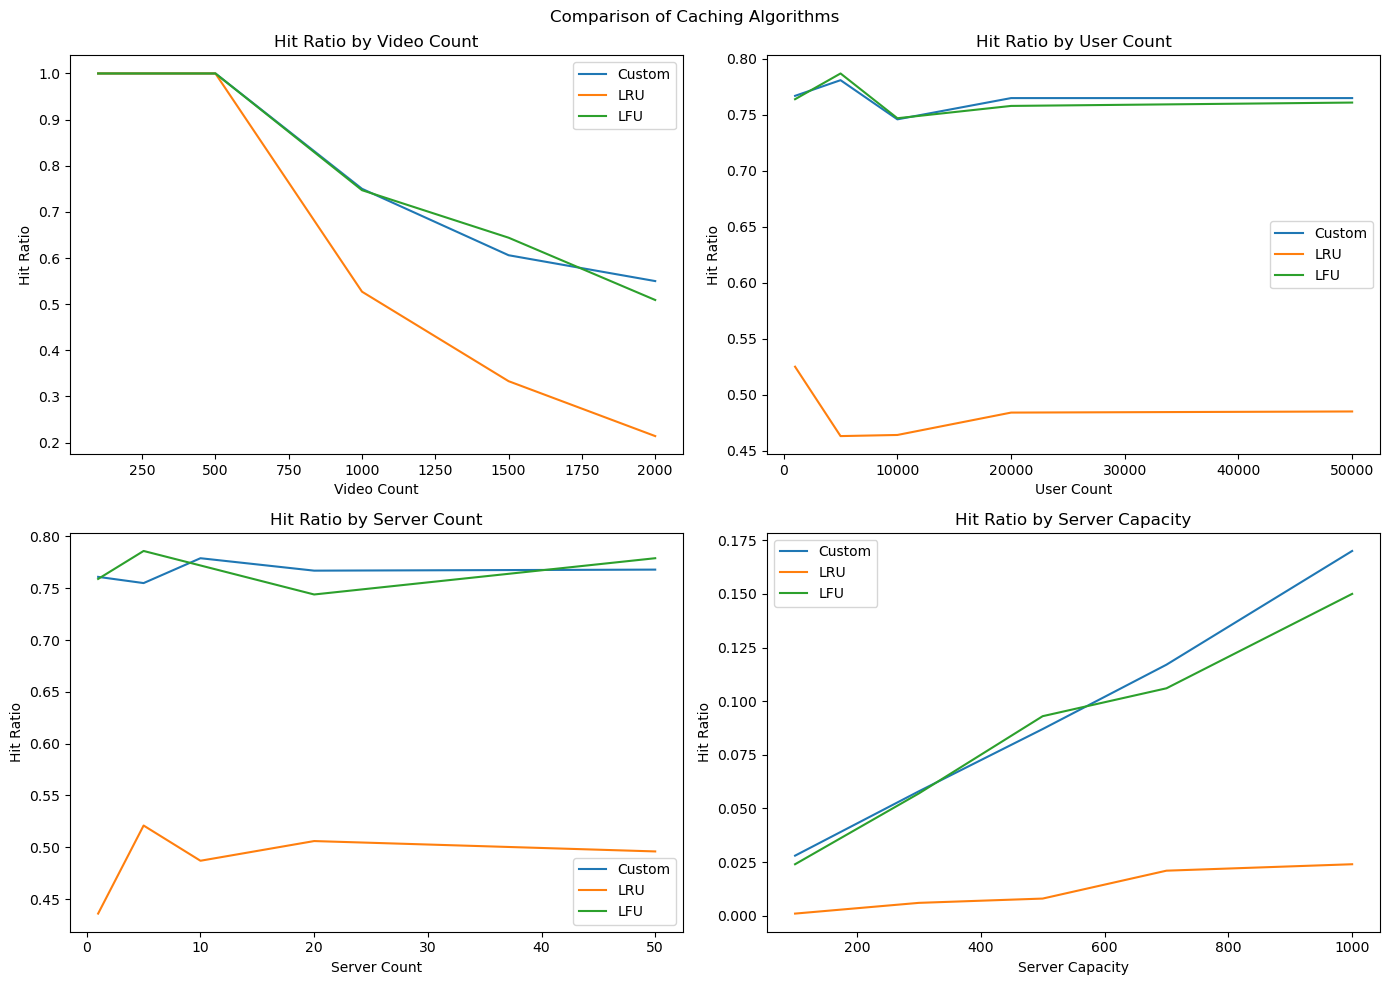

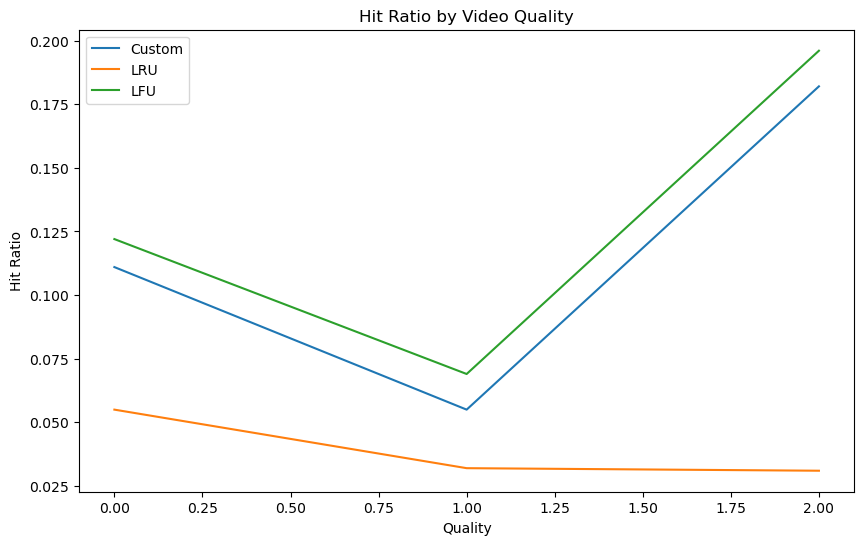

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from prophet import Prophet
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('GBvideos_with_quality.csv')

# Convert date format
data['publish_time'] = pd.to_datetime(data['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

# Handle missing values
data = data.dropna(subset=['views', 'likes', 'publish_time', 'tags', 'category_id', 'quality', 'adjusted_views'])

# Label encoding for tags
label_encoder = LabelEncoder()
data['tags'] = label_encoder.fit_transform(data['tags'])

# Label encoding for quality
quality_encoder = LabelEncoder()
data['quality'] = quality_encoder.fit_transform(data['quality'])

# Time of day for publishing time
data['time_of_day'] = data['publish_time'].dt.hour // 6  # Divide time into four segments
category_ids = data['category_id'].unique()

# Define custom Prophet model class
class CustomProphet(Prophet):
    def __init__(self, custom_trend_param=0.5, custom_seasonality_param=1.0, **kwargs):
        # Adjust default model parameters
        super().__init__(**kwargs)
        self.custom_trend_param = custom_trend_param
        self.custom_seasonality_param = custom_seasonality_param
        self.custom_regressors = []

    def add_custom_regressor(self, name, **kwargs):
        self.custom_regressors.append(name)
        self.add_regressor(name, **kwargs)

    def fit(self, df, **kwargs):
        # Add custom seasonal component
        # For example: Add a quarterly seasonal component (period = 90.25 days)
        self.add_seasonality(name='quarterly', period=90.25, fourier_order=8)
        super().fit(df, **kwargs)
        self.params['custom_trend'] = self._fit_custom_trend(df)
        self.params['custom_seasonality'] = self._fit_custom_seasonality(df)
        self.params['custom_regressors'] = self._fit_custom_regressors(df)
        return self

    def _fit_custom_trend(self, df):
        dates = pd.to_datetime(df['ds']).map(pd.Timestamp.toordinal).values
        y = df['y'].values
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
        model.fit(dates.reshape(-1, 1), y)
        self.custom_trend_model = model
        return model

    def _predict_custom_trend(self, df):
        if hasattr(self, 'custom_trend_model'):
            dates = pd.to_datetime(df['ds']).map(pd.Timestamp.toordinal).values
            trend = self.custom_trend_model.predict(dates.reshape(-1, 1))
            return trend
        else:
            raise ValueError("Custom trend model has not been fitted.")

    def _fit_custom_seasonality(self, df):
        dates = pd.to_datetime(df['ds']).map(pd.Timestamp.toordinal).values
        y = df['y'].values
        from sklearn.preprocessing import PolynomialFeatures
        poly = PolynomialFeatures(degree=4)
        dates_poly = poly.fit_transform(dates.reshape(-1, 1))
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
        model.fit(dates_poly, y)
        self.custom_seasonality_model = model
        self.poly = poly
        return model

    def _predict_custom_seasonality(self, df):
        if hasattr(self, 'custom_seasonality_model'):
            dates = pd.to_datetime(df['ds']).map(pd.Timestamp.toordinal).values
            dates_poly = self.poly.transform(dates.reshape(-1, 1))
            seasonality = self.custom_seasonality_model.predict(dates_poly)
            return seasonality
        else:
            raise ValueError("Custom seasonality model has not been fitted.")

    def _fit_custom_regressors(self, df):
        regressors = df[self.custom_regressors]
        y = df['y'].values
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
        model.fit(regressors, y)
        self.custom_regressors_model = model
        return model

    def _predict_custom_regressors(self, df):
        if hasattr(self, 'custom_regressors_model'):
            regressors = df[self.custom_regressors]
            regressors_pred = self.custom_regressors_model.predict(regressors)
            return regressors_pred
        else:
            raise ValueError("Custom regressors model has not been fitted.")

    def predict(self, df):
        forecast = super().predict(df)
        forecast['custom_trend'] = self._predict_custom_trend(df)
        forecast['custom_seasonality'] = self._predict_custom_seasonality(df)
        forecast['custom_regressors'] = self._predict_custom_regressors(df)
        forecast['yhat'] += (forecast['custom_trend'] +
                             forecast['custom_seasonality'] +
                             forecast['custom_regressors'])
        forecast['yhat'] = forecast['yhat'].apply(lambda x: max(0, x))
        return forecast

# Add external regressor variables
def get_predictions(category_data):
    df = pd.DataFrame()
    df['ds'] = category_data['publish_time']
    df['y'] = category_data['adjusted_views']
    df['tags'] = category_data['tags']
    df['likes'] = category_data['likes']
    df['quality'] = category_data['quality']
    df['time_of_day'] = category_data['time_of_day']

    # Additional external regressors
    df['like_rate'] = category_data['likes'] / category_data['views']
    df['days_since_publish'] = (df['ds'] - df['ds'].min()).dt.days
    df['is_weekend'] = df['ds'].dt.weekday.isin([5, 6]).astype(int)

    model = CustomProphet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='multiplicative')
    model.add_custom_regressor('tags')
    model.add_custom_regressor('likes')
    model.add_custom_regressor('quality')
    model.add_custom_regressor('days_since_publish')
    model.add_custom_regressor('is_weekend')
    model.add_custom_regressor('time_of_day')
    model.add_custom_regressor('like_rate')

    model.fit(df)

    future = model.make_future_dataframe(periods=365)
    future['tags'] = 0
    future['likes'] = 0
    future['quality'] = 0
    future['time_of_day'] = 0
    future['days_since_publish'] = (future['ds'] - df['ds'].min()).dt.days
    future['is_weekend'] = future['ds'].dt.weekday.isin([5, 6]).astype(int)
    future['like_rate'] = 0

    forecast = model.predict(future)
    forecast['category_id'] = category_data['category_id'].iloc[0]
    forecast['quality'] = category_data['quality'].iloc[0]
    return forecast

# Collect all forecasts
all_forecasts = []
for category_id in category_ids:
    category_data = data[data['category_id'] == category_id]
    forecast = get_predictions(category_data)
    all_forecasts.append(forecast)

# Combine all forecasts
all_forecasts_df = pd.concat(all_forecasts).reset_index(drop=True)
# Add adjusted_views column after merging all forecasts
all_forecasts_df['adjusted_views'] = all_forecasts_df['yhat']  # Assuming adjusted_views is based on yhat

# Define function to calculate hit ratio
def calculate_custom_hit_ratio(df, cache_size, total_requests=1000):
    df_sorted = df.sort_values(by='yhat', ascending=False)
    cached_videos = df_sorted.head(cache_size)
    cached_video_ids = set(cached_videos.index)

    hits = 0
    for i in range(total_requests):
        requested_video = np.random.choice(df.index, p=df['yhat']/df['yhat'].sum())
        if requested_video in cached_video_ids:
            hits += 1
    
    cache_hit_ratio = hits / total_requests
    return cache_hit_ratio

def calculate_LRU_hit_ratio(df, cache_size, total_requests=1000):
    df_sorted = df.sort_values(by='ds', ascending=False)
    cached_videos = df_sorted.head(cache_size)
    cached_video_ids = set(cached_videos.index)

    hits = 0
    for i in range(total_requests):
        requested_video = np.random.choice(df.index, p=df['adjusted_views']/df['adjusted_views'].sum())
        if requested_video in cached_video_ids:
            hits += 1

    cache_hit_ratio = hits / total_requests
    return cache_hit_ratio

def calculate_LFU_hit_ratio(df, cache_size, total_requests=1000):
    df_sorted = df.sort_values(by='adjusted_views', ascending=False)
    cached_videos = df_sorted.head(cache_size)
    cached_video_ids = set(cached_videos.index)

    hits = 0
    for i in range(total_requests):
        requested_video = np.random.choice(df.index, p=df['adjusted_views']/df['adjusted_views'].sum())
        if requested_video in cached_video_ids:
            hits += 1

    cache_hit_ratio = hits / total_requests
    return cache_hit_ratio

# Define dictionary for algorithms
algorithms = {
    'Custom': calculate_custom_hit_ratio,
    'LRU': calculate_LRU_hit_ratio,
    'LFU': calculate_LFU_hit_ratio
}

# Initialize result storage
results = {
    'video_counts': [],
    'user_counts': [],
    'server_counts': [],
    'server_capacities': [],
    'quality_levels': []
}

# Use algorithms
video_counts = [100, 500, 1000, 1500, 2000]
for count in video_counts:
    subset = all_forecasts_df.sample(n=count)
    for alg_name, alg_func in algorithms.items():
        cache_hit_ratio = alg_func(subset, cache_size=500)
        results['video_counts'].append((count, 'All Qualities', alg_name, cache_hit_ratio))

# Simulate different user counts
user_counts = [1000, 5000, 10000, 20000, 50000]
for users in user_counts:
    subset = all_forecasts_df.sample(n=1000)
    for alg_name, alg_func in algorithms.items():
        cache_hit_ratio = alg_func(subset, cache_size=500)
        results['user_counts'].append((users, 'All Qualities', alg_name, cache_hit_ratio))

# Simulate different server counts
server_counts = [1, 5, 10, 20, 50]
for servers in server_counts:
    subset = all_forecasts_df.sample(n=1000)
    for alg_name, alg_func in algorithms.items():
        cache_hit_ratio = alg_func(subset, cache_size=500)
        results['server_counts'].append((servers, 'All Qualities', alg_name, cache_hit_ratio))

# Simulate different server capacities
server_capacities = [100, 300, 500, 700, 1000]
for capacity in server_capacities:
    subset = all_forecasts_df
    for alg_name, alg_func in algorithms.items():
        cache_hit_ratio = alg_func(subset, cache_size=capacity)
        results['server_capacities'].append((capacity, 'All Qualities', alg_name, cache_hit_ratio))

# Simulate different video qualities
quality_levels = data['quality'].unique()
for quality in quality_levels:
    subset = all_forecasts_df[all_forecasts_df['quality'] == quality]
    for alg_name, alg_func in algorithms.items():
        cache_hit_ratio = alg_func(subset, cache_size=500)
        results['quality_levels'].append((quality, alg_name, cache_hit_ratio))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparison of Caching Algorithms')

# Plot by video count
video_counts_df = pd.DataFrame(results['video_counts'], columns=['Video Count', 'Quality', 'Algorithm', 'Hit Ratio'])
for alg in video_counts_df['Algorithm'].unique():
    subset = video_counts_df[video_counts_df['Algorithm'] == alg]
    axes[0, 0].plot(subset['Video Count'], subset['Hit Ratio'], label=alg)
axes[0, 0].set_title('Hit Ratio by Video Count')
axes[0, 0].set_xlabel('Video Count')
axes[0, 0].set_ylabel('Hit Ratio')
axes[0, 0].legend()

# Plot by user count
user_counts_df = pd.DataFrame(results['user_counts'], columns=['User Count', 'Quality', 'Algorithm', 'Hit Ratio'])
for alg in user_counts_df['Algorithm'].unique():
    subset = user_counts_df[user_counts_df['Algorithm'] == alg]
    axes[0, 1].plot(subset['User Count'], subset['Hit Ratio'], label=alg)
axes[0, 1].set_title('Hit Ratio by User Count')
axes[0, 1].set_xlabel('User Count')
axes[0, 1].set_ylabel('Hit Ratio')
axes[0, 1].legend()

# Plot by server count
server_counts_df = pd.DataFrame(results['server_counts'], columns=['Server Count', 'Quality', 'Algorithm', 'Hit Ratio'])
for alg in server_counts_df['Algorithm'].unique():
    subset = server_counts_df[server_counts_df['Algorithm'] == alg]
    axes[1, 0].plot(subset['Server Count'], subset['Hit Ratio'], label=alg)
axes[1, 0].set_title('Hit Ratio by Server Count')
axes[1, 0].set_xlabel('Server Count')
axes[1, 0].set_ylabel('Hit Ratio')
axes[1, 0].legend()

# Plot by server capacity
server_capacities_df = pd.DataFrame(results['server_capacities'], columns=['Server Capacity', 'Quality', 'Algorithm', 'Hit Ratio'])
for alg in server_capacities_df['Algorithm'].unique():
    subset = server_capacities_df[server_capacities_df['Algorithm'] == alg]
    axes[1, 1].plot(subset['Server Capacity'], subset['Hit Ratio'], label=alg)
axes[1, 1].set_title('Hit Ratio by Server Capacity')
axes[1, 1].set_xlabel('Server Capacity')
axes[1, 1].set_ylabel('Hit Ratio')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Plot by video quality
plt.figure(figsize=(10, 6))
quality_levels_df = pd.DataFrame(results['quality_levels'], columns=['Quality', 'Algorithm', 'Hit Ratio'])
for alg in quality_levels_df['Algorithm'].unique():
    subset = quality_levels_df[quality_levels_df['Algorithm'] == alg]
    plt.plot(subset['Quality'], subset['Hit Ratio'], label=alg)
plt.title('Hit Ratio by Video Quality')
plt.xlabel('Quality')
plt.ylabel('Hit Ratio')
plt.legend()
plt.show()
